In [1]:
!pip install torch==2.7.0
!pip install torch-geometric
!pip install biopython
!pip install obonet
!pip install networkx
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install fair-esm

In [2]:
import os
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import Bio
from Bio import SeqIO
import obonet
import gc
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import esm


In [3]:
SAMPLE = .02

In [4]:
obo_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo'
fasta_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta'
term_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv'
taxonomy_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv'

In [5]:
 term_df = pd.read_csv(term_path, sep='\t')

In [6]:
term_df[term_df["EntryID"] == "A0A0C5B5G6"]

,EntryID,term,aspect
484617,A0A0C5B5G6,GO:0001649,P
484618,A0A0C5B5G6,GO:0033687,P
484619,A0A0C5B5G6,GO:0005615,C
484620,A0A0C5B5G6,GO:0005634,C
484621,A0A0C5B5G6,GO:0005739,C
484622,A0A0C5B5G6,GO:0043610,P
484623,A0A0C5B5G6,GO:2001145,P
484624,A0A0C5B5G6,GO:0032147,P
484625,A0A0C5B5G6,GO:0006357,P
484626,A0A0C5B5G6,GO:0048630,P


In [7]:
 taxonomy_df = pd.read_csv(taxonomy_path, sep='\t')

In [8]:
taxonomy_df.head()

,A0A0C5B5G6,9606
0,A0JNW5,9606
1,A0JP26,9606
2,A0PK11,9606
3,A1A4S6,9606
4,A1A519,9606


In [9]:
fasta_data = list(SeqIO.parse(fasta_path, "fasta"))

In [10]:
fasta_data[:5]

[SeqRecord(seq=Seq('MRWQEMGYIFYPRKLR'), id='sp|A0A0C5B5G6|MOTSC_HUMAN', name='sp|A0A0C5B5G6|MOTSC_HUMAN', description='sp|A0A0C5B5G6|MOTSC_HUMAN Mitochondrial-derived peptide MOTS-c OS=Homo sapiens OX=9606 GN=MT-RNR1 PE=1 SV=1', dbxrefs=[]),
 SeqRecord(seq=Seq('MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPT...TVE'), id='sp|A0JNW5|BLT3B_HUMAN', name='sp|A0JNW5|BLT3B_HUMAN', description='sp|A0JNW5|BLT3B_HUMAN Bridge-like lipid transfer protein family member 3B OS=Homo sapiens OX=9606 GN=BLTP3B PE=1 SV=2', dbxrefs=[]),
 SeqRecord(seq=Seq('MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTSGDHDDSFM...TSI'), id='sp|A0JP26|POTB3_HUMAN', name='sp|A0JP26|POTB3_HUMAN', description='sp|A0JP26|POTB3_HUMAN POTE ankyrin domain family member B3 OS=Homo sapiens OX=9606 GN=POTEB3 PE=1 SV=2', dbxrefs=[]),
 SeqRecord(seq=Seq('MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDLVNATDREL...ILY'), id='sp|A0PK11|CLRN2_HUMAN', name='sp|A0PK11|CLRN2_HUMAN', description='sp|A0PK11|CLRN2_HUMAN Clarin-2 OS=Homo sap

# EDA

## Counting subontologies 

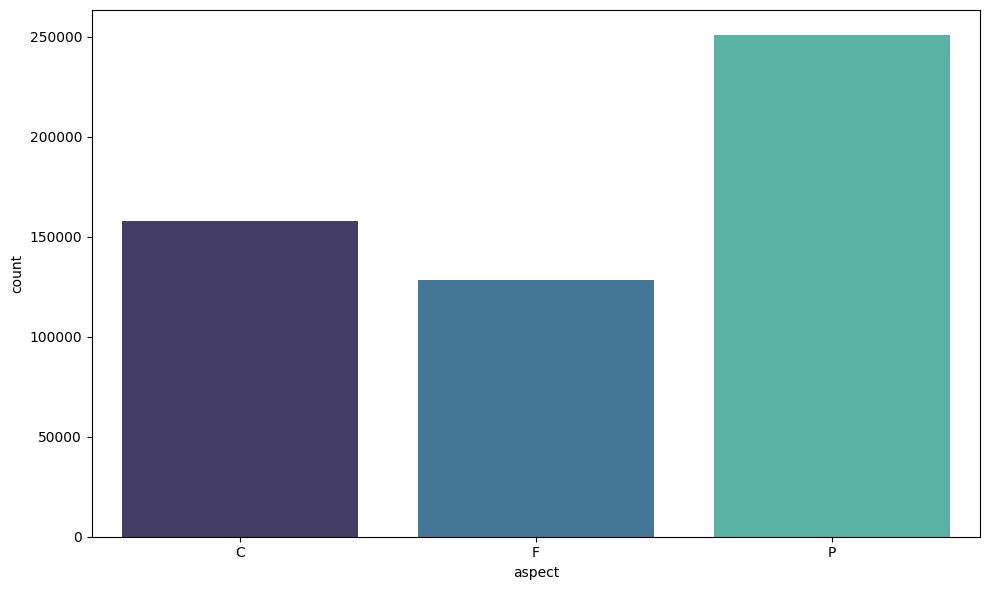

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(data=term_df, x='aspect', palette='mako')
plt.tight_layout()
plt.show()

## Counting terms for Cellular Component

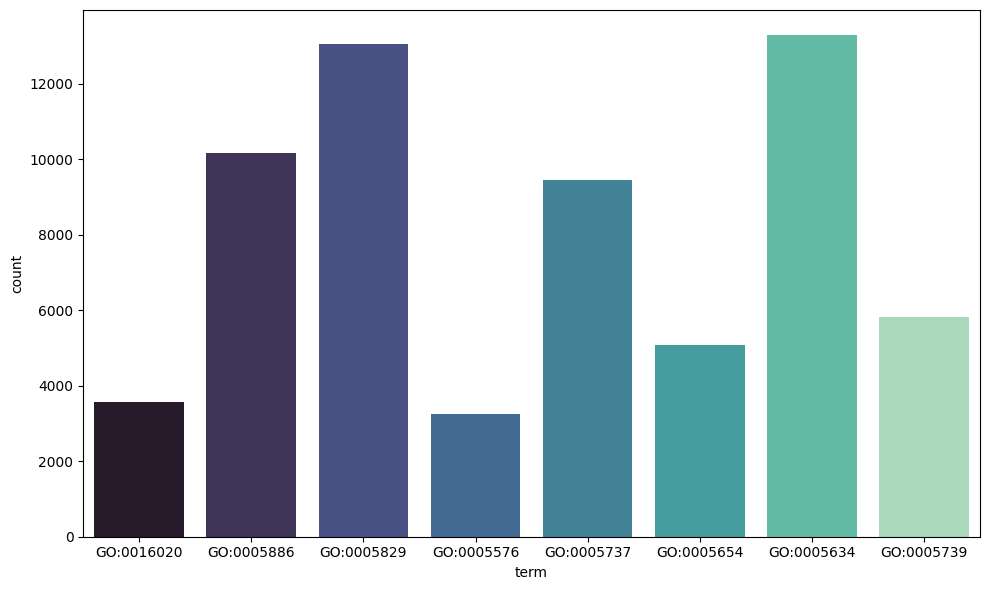

In [12]:
k = 8
k_most_common_c_term_counts = term_df[term_df['aspect'] == 'C']['term'].value_counts().head(k)
k_most_common_c_term = [term for term in k_most_common_c_term_counts.index]
plt.figure(figsize=(10, 6))
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_c_term)], x='term', palette='mako')
plt.tight_layout()
plt.show()

## Counting terms for Molecular Function

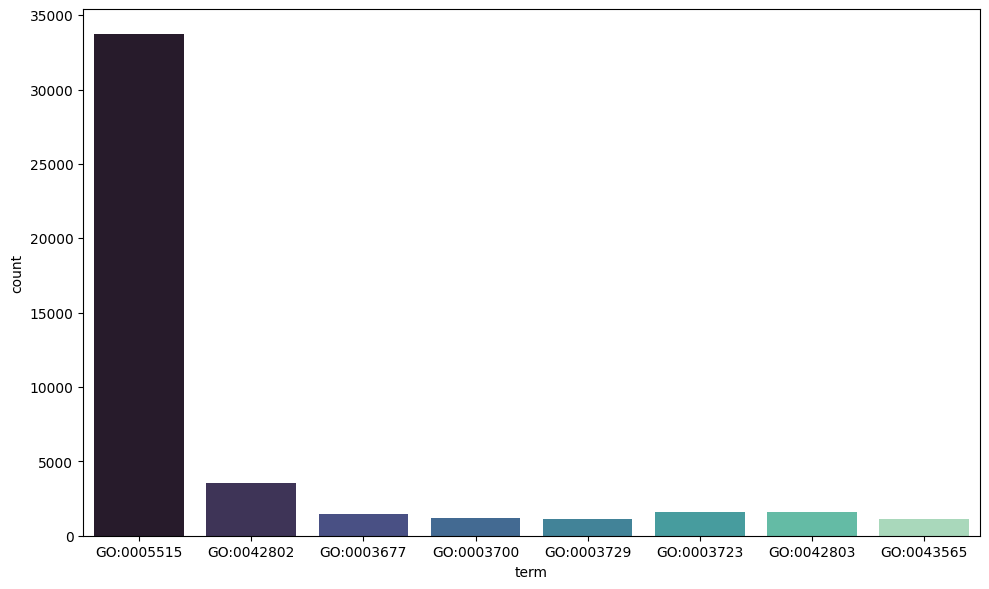

In [13]:
k_most_common_f_term_counts = term_df[term_df['aspect'] == 'F']['term'].value_counts().head(k)
k_most_common_f_term = [term for term in k_most_common_f_term_counts.index]
plt.figure(figsize=(10, 6))
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_f_term)], x='term', palette='mako')
plt.tight_layout()
plt.show()

## Counting terms for Biological Process

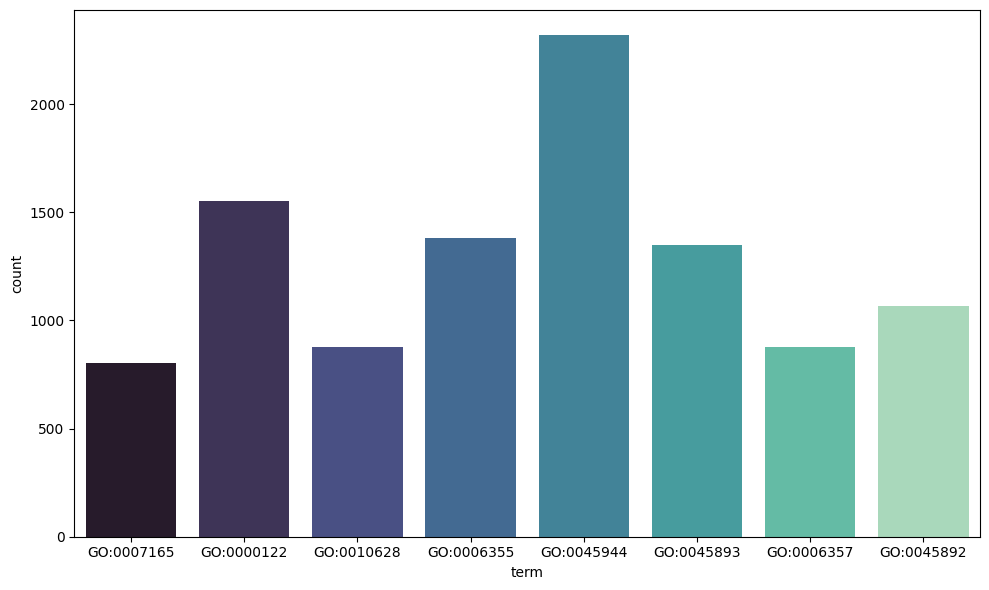

In [14]:
k_most_common_p_term_counts = term_df[term_df['aspect'] == 'P']['term'].value_counts().head(k)
k_most_common_p_term = [term for term in k_most_common_p_term_counts.index]
plt.figure(figsize=(10, 6))
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_p_term)], x='term', palette='mako')
plt.tight_layout()
plt.show()

In [16]:
graph = obonet.read_obo(obo_path)


nodes = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')
nodes.reset_index(inplace=True)
nodes.rename(columns={'index': 'id'}, inplace=True)

edges = pd.DataFrame([
    {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
    for u, v, data in graph.edges(data=True)
])


print("Number of nodes:", len(nodes))
print("Number of edges:", len(edges))

print("\nSample nodes:")
print(nodes.head())

print("\nSample edges:")
print(edges.head())

Number of nodes: 40122
Number of edges: 77229

Sample nodes:
           id                                               name  \
0  GO:0000001                          mitochondrion inheritance   
1  GO:0000002                   mitochondrial genome maintenance   
2  GO:0000006  high-affinity zinc transmembrane transporter a...   
3  GO:0000007  low-affinity zinc ion transmembrane transporte...   
4  GO:0000009             alpha-1,6-mannosyltransferase activity   

            namespace                                                def  \
0  biological_process  "The distribution of mitochondria, including t...   
1  biological_process  "The maintenance of the structure and integrit...   
2  molecular_function  "Enables the transfer of zinc ions (Zn2+) from...   
3  molecular_function  "Enables the transfer of a solute or solutes f...   
4  molecular_function  "Catalysis of the transfer of a mannose residu...   

                                             synonym  \
0             ["m

In [17]:
list(graph.nodes())[:5], list(graph.edges())[:5]

(['GO:0000001', 'GO:0000002', 'GO:0000006', 'GO:0000007', 'GO:0000009'],
 [('GO:0000001', 'GO:0048308'),
  ('GO:0000001', 'GO:0048311'),
  ('GO:0000002', 'GO:0007005'),
  ('GO:0000006', 'GO:0005385'),
  ('GO:0000007', 'GO:0005385')])

### Visualize the GO graph for 1% sampled edges

Loaded 40122 nodes and 77229 edges
Sampled 77 edges
Subgraph has 154 nodes and 77 edges


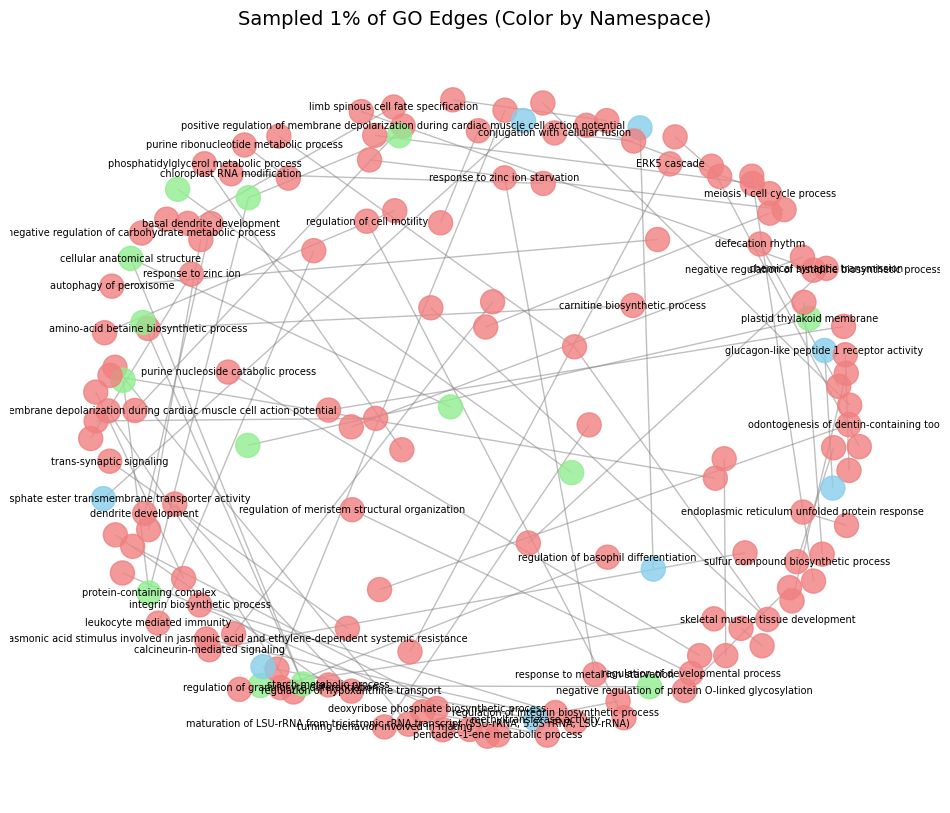

In [18]:

nodes = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index').reset_index()
nodes.rename(columns={'index': 'id'}, inplace=True)

edges = pd.DataFrame([
    {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
    for u, v, data in graph.edges(data=True)
])

print(f"Loaded {len(nodes)} nodes and {len(edges)} edges")

# ------------------------------
# Step 3: Sample 1% of edges
# ------------------------------
sampled_edges = edges.sample(frac=0.001, random_state=42).reset_index(drop=True)
print(f"Sampled {len(sampled_edges)} edges")


sampled_node_ids = set(sampled_edges['source']).union(set(sampled_edges['target']))
sampled_nodes = nodes[nodes['id'].isin(sampled_node_ids)]

print(f"Subgraph has {len(sampled_nodes)} nodes and {len(sampled_edges)} edges")


subgraph = graph.subgraph(sampled_node_ids).copy()


plt.figure(figsize=(12, 10))

pos = nx.spring_layout(subgraph, k=0.8, seed=42)


namespace_colors = {
    'biological_process': 'lightcoral',
    'molecular_function': 'skyblue',
    'cellular_component': 'lightgreen'
}
node_colors = [
    namespace_colors.get(subgraph.nodes[n].get('namespace', ''), 'gray')
    for n in subgraph.nodes()
]


nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=300, alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, arrows=False, edge_color='gray', alpha=0.5)


label_nodes = dict(list(subgraph.nodes(data=True))[:50])
nx.draw_networkx_labels(
    subgraph,
    pos,
    labels={n: d.get('name', n) for n, d in label_nodes.items()},
    font_size=7
)

plt.title("Sampled 1% of GO Edges (Color by Namespace)", fontsize=14)
plt.axis('off')
plt.show()


### Create set of embedding from the graph edges using GCN

In [19]:
# ---------------------------------------------------
# Read TSV and Sample by EntryID
# ---------------------------------------------------
def sample_tsv(file_path, sample_frac=0.05, random_state=42):
    """
    Read a TSV file and sample based on unique EntryID.
    Pulls in all associated rows for sampled EntryIDs.
    """
    df = pd.read_csv(file_path, sep='\t')
    unique_ids = df['EntryID'].unique()
    sample_size = max(1, int(len(unique_ids) * sample_frac))
    sampled_ids = random.sample(list(unique_ids), sample_size)
    sampled_df = df[df['EntryID'].isin(sampled_ids)]
    print(f"Sampled {len(sampled_df)} rows from {len(unique_ids)} unique EntryIDs")
    return sampled_df


In [20]:
def create_go_embeddings_optimized(obo_path, go_terms, embed_dim=16, hidden_dim=32, out_dim=16, epochs=50):

    print(" Loading Gene Ontology...")
    graph = obonet.read_obo(obo_path)


    edges = pd.DataFrame([
        {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
        for u, v, data in graph.edges(data=True)
    ])

    relevant_edges = edges[
        edges['source'].isin(go_terms) | edges['target'].isin(go_terms)
    ].reset_index(drop=True)

    nodes = pd.DataFrame({'id': list(set(relevant_edges['source']).union(relevant_edges['target']))})
    nodes['node_idx'] = range(len(nodes))
    node2idx = dict(zip(nodes['id'], nodes['node_idx']))

    edge_index = torch.tensor([
        [node2idx[s] for s in relevant_edges['source']],
        [node2idx[t] for t in relevant_edges['target']]
    ], dtype=torch.long)

    num_nodes = len(nodes)
    print(f"Using {num_nodes} GO terms and {len(relevant_edges)} edges")


    x = torch.randn((num_nodes, embed_dim), dtype=torch.float32)


    class SimpleGCN(nn.Module):
        def __init__(self, in_dim, hidden_dim, out_dim):
            super(SimpleGCN, self).__init__()
            self.conv1 = GCNConv(in_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
            self.conv3 = GCNConv(hidden_dim, out_dim)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = self.conv2(x, edge_index)
            x = F.relu(x)
            x = self.conv3(x, edge_index)
            
            return x

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleGCN(embed_dim, hidden_dim, out_dim).to(device)


    x = x.to(device)
    edge_index = edge_index.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    data = Data(x=x, edge_index=edge_index)

    print(f"Training on device: {device}")
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index)
        # Inner product decoder
        recon = torch.sigmoid(torch.matmul(embeddings, embeddings.T))
        adj_true = torch.zeros_like(recon)
        adj_true[data.edge_index[0], data.edge_index[1]] = 1.0

        loss = F.binary_cross_entropy(recon, adj_true)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")


    with torch.no_grad():
        node_embeddings = model(data.x, data.edge_index).cpu().numpy()

    del model, x, data, recon, adj_true
    torch.cuda.empty_cache()
    gc.collect()

    col_names = [f"go_emb_{i}" for i in range(node_embeddings.shape[1])]

    emb_df = pd.DataFrame(node_embeddings, index=nodes['id'], columns=col_names)
    print(f"Created embeddings for {len(emb_df)} GO terms")
    return emb_df





In [21]:
# ---------------------------------------------------
# Pull protein sequences from FASTA file
# ---------------------------------------------------
def extract_sequences(fasta_path, entry_ids):
    records = []
    entry_ids = set(entry_ids)
    for record in SeqIO.parse(fasta_path, "fasta"):
        # Typical Uniprot headers: ">sp|P12345|PROT_HUMAN ..."
        label = record.id.split('|')[1] if '|' in record.id else record.id
        if label in entry_ids:
            records.append({
                'EntryID': label,
                'Sequence': str(record.seq)
            })
    seq_df = pd.DataFrame(records)
    print(f"Retrieved {len(seq_df)} sequences matching EntryIDs")
    return seq_df



### Sample 0.5% of the data and create embedding based on that

In [22]:
sampled_data = sample_tsv(term_path, sample_frac=SAMPLE)
go_terms = sampled_data['term'].unique()
embeddings_df = create_go_embeddings_optimized(obo_path, go_terms)
seq_df = extract_sequences(fasta_path, sampled_data['EntryID'],)

Sampled 10546 rows from 82404 unique EntryIDs
 Loading Gene Ontology...
Using 18592 GO terms and 22791 edges
Training on device: cuda
Epoch 000 | Loss: 2.7230
Epoch 010 | Loss: 0.7519
Epoch 020 | Loss: 0.7142
Epoch 030 | Loss: 0.7006
Epoch 040 | Loss: 0.6953
Epoch 049 | Loss: 0.6940
Created embeddings for 18592 GO terms
Retrieved 1648 sequences matching EntryIDs


In [23]:
[seq_df.Sequence.to_numpy()[0]]


['MSPTISHKDSSRQRRPGNFSHSLDMKSGPLPPGGWDDSHLDSAGREGDREALLGDTGTGDFLKAPQSFRAELSSILLLLFLYVLQGIPLGLAGSIPLILQSKNVSYTDQAFFSFVFWPFSLKLLWAPLVDAVYVKNFGRRKSWLVPTQYILGLFMIYLSTQVDRLLGNTDDRTPDVIALTVAFFLFEFLAATQDIAVDGWALTMLSRENVGYASTCNSVGQTAGYFLGNVLFLALESADFCNKYLRFQPQPRGIVTLSDFLFFWGTVFLITTTLVALLKKENEVSVVKEETQGITDTYKLLFAIIKMPAVLTFCLLILTAKIGFSAADAVTGLKLVEEGVPKEHLALLAVPMVPLQIILPLIISKYTAGPQPLNTFYKAMPYRLLLGLEYALLVWWTPKVEHQGGFPIYYYIVVLLSYALHQVTVYSMYVSIMAFNAKVSDPLIGGTYMTLLNTVSNLGGNWPSTVALWLVDPLTVKECVGASNQNCRTPDAVELCKKLGGSCVTALDGYYVESIICVFIGFGWWFFLGPKFKKLQDEGSSSWKCKRNN']

In [24]:
sampled_data.head()

,EntryID,term,aspect
635,Q5T5C0,GO:0005829,C
639,P98131,GO:0016020,C
1197,Q9U405,GO:0007279,P
1198,Q9U405,GO:0007349,P
1199,Q9U405,GO:0000987,F


### Create embedding using Protein Language Model

In [25]:
model, alphabet = esm.pretrained.esm2_t30_150M_UR50D()

In [26]:
%config Completer.use_jedi = False

In [27]:
def generate_protein_embeddings_esm_optimized(seq_df, seq_col='Sequence', entryid_col='EntryID',
                                              target_dim=16, batch_size=1, use_fp16=True):
    """
    Memory-optimized ESM embedding generation for proteins.
    Processes small batches and moves embeddings to CPU immediately.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load pretrained ESM model
    model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
    model = model.to(device)
    model.eval()
    print(1)
    batch_converter = alphabet.get_batch_converter()

    sequences = seq_df[seq_col].tolist()
    entry_ids = seq_df[entryid_col].tolist()

    all_embeddings = []
    print(len(sequences))
    for i in range(0, len(sequences), batch_size):
        batch_seqs = sequences[i:i+batch_size]
        batch_labels = entry_ids[i:i+batch_size]

        batch_data = [(label, seq) for label, seq in zip(batch_labels, batch_seqs)]
        _, _, batch_tokens = batch_converter(batch_data) # returns label, seq and batch_tokens
        batch_tokens = batch_tokens.to(device)
        if not i%20:
            print(i)
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False)
            token_embeddings = results["representations"][model.num_layers]  # (B, L, D)

            # Mean pool over sequence length
            attention_mask = batch_tokens != alphabet.padding_idx # If a batch has the padding_idx it should be 0 in the next line
            masked_embeddings = token_embeddings * attention_mask.unsqueeze(-1)
            seq_lengths = attention_mask.sum(dim=1).unsqueeze(-1) # get lengths of sequences to normalize
            seq_embeddings = (masked_embeddings.sum(dim=1) / seq_lengths).cpu().float().numpy()

        all_embeddings.append(seq_embeddings)
        del batch_tokens, token_embeddings, masked_embeddings, seq_embeddings
        torch.cuda.empty_cache()

    raw_embeddings = np.vstack(all_embeddings)
    print("Raw embeddings shape:", raw_embeddings.shape)

    if raw_embeddings.shape[1] > target_dim:
        # If our raw embeddings have a higher target dimension, we can use relevant principal components
        # for dimensionality reduction
        pca = PCA(n_components=target_dim)
        reduced = pca.fit_transform(raw_embeddings)
    else:
        # Pad with zeros to ensure we have the right dimension
        reduced = np.zeros((raw_embeddings.shape[0], target_dim), dtype=np.float32)
        reduced[:, :raw_embeddings.shape[1]] = raw_embeddings

    col_names = [f"prot_emb_{i}" for i in range(target_dim)]
    emb_df = pd.DataFrame(reduced, index=entry_ids, columns=col_names)
    emb_df.index.name = entryid_col
    print("Reduced embeddings shape:", emb_df.shape)
    return emb_df


prot_emb_df = generate_protein_embeddings_esm_optimized(seq_df, seq_col='Sequence', entryid_col='EntryID', target_dim=16)

# Merge with sampled_data if needed
merged = sampled_data.merge(prot_emb_df, how='left', left_on='EntryID', right_index=True)
print(merged.head())


Using device: cuda
1
1648
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
Raw embeddings shape: (1648, 320)
Reduced embeddings shape: (1648, 16)
     EntryID        term aspect  prot_emb_0  prot_emb_1  prot_emb_2  \
635   Q5T5C0  GO:0005829      C    0.056460    0.457785   -0.124763   
639   P98131  GO:0016020      C    1.284640    0.454131   -0.460353   
1197  Q9U405  GO:0007279      P    0.440263    0.399838    0.471996   
1198  Q9U405  GO:0007349      P    0.440263    0.399838    0.471996   
1199  Q9U405  GO:0000987      F    0.440263    0.399838    0.471996   

      prot_emb_3  prot_emb_4  prot_emb_5  prot_emb_6  prot_emb_7  prot_emb_8  \
635    -0.349875    0.077374   -0.007

In [28]:
sampled_data

,EntryID,term,aspect
635,Q5T5C0,GO:0005829,C
639,P98131,GO:0016020,C
1197,Q9U405,GO:0007279,P
1198,Q9U405,GO:0007349,P
1199,Q9U405,GO:0000987,F
...,...,...,...
536802,Q70CQ2,GO:0004197,F
536803,Q70CQ2,GO:0005515,F
536804,Q70CQ2,GO:0005829,C
536805,Q70CQ2,GO:0016055,P


### Combine GO embedding and PLM embedding into one dataset

In [29]:
def combine_go_protein_embeddings(sampled_data, go_emb_df, prot_emb_df):

    combined = sampled_data.merge(go_emb_df, how='left', left_on='term', right_index=True)

    combined = combined.merge(prot_emb_df, how='left', left_on='EntryID', right_index=True)

    return combined


multimodal_df = combine_go_protein_embeddings(sampled_data, embeddings_df, prot_emb_df)

print("Multimodal feature dataframe shape:", multimodal_df.shape)
print(multimodal_df.head())

Multimodal feature dataframe shape: (10546, 35)
     EntryID        term aspect  go_emb_0  go_emb_1  go_emb_2  go_emb_3  \
635   Q5T5C0  GO:0005829      C  0.162332  0.050733  0.194814 -0.209321   
639   P98131  GO:0016020      C  0.069903  0.092173 -0.123378  0.011945   
1197  Q9U405  GO:0007279      P  0.063452 -0.060349  0.022883 -0.085866   
1198  Q9U405  GO:0007349      P -0.033171  0.141319 -0.035098 -0.052075   
1199  Q9U405  GO:0000987      F -0.016944  0.009780  0.059183  0.000613   

      go_emb_4  go_emb_5  go_emb_6  ...  prot_emb_6  prot_emb_7  prot_emb_8  \
635   0.108329  0.017446 -0.064398  ...    0.016303   -0.215723    0.263217   
639   0.014617  0.107672  0.073210  ...    0.493312   -1.064042   -0.203821   
1197 -0.057188 -0.053641 -0.034259  ...    0.402892    0.255416   -0.104149   
1198  0.000246  0.001460 -0.114119  ...    0.402892    0.255416   -0.104149   
1199  0.028401  0.026207 -0.027187  ...    0.402892    0.255416   -0.104149   

      prot_emb_9  prot_emb

### Create a simple NN model for baseline

In [30]:
feature_cols = [col for col in multimodal_df.columns if col.startswith('prot_emb_')]

# If we are using GO embedding as well
# feature_cols = [col for col in multimodal_df.columns if col.startswith('go_emb_') or col.startswith('prot_emb_')]
X = multimodal_df[feature_cols].values
y = multimodal_df['aspect'].values


le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)


X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [31]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    num_class=3,
    objective='multi:softmax'
    
)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1, num_class=3,
              num_parallel_tree=None, ...)

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make sure both are mapped the same way
y_pred = xgb_model.predict(X_val)

# Basic accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# print(f"Number of correct predictions: {np.sum(y_val == y_pred)}/{len(y_val)}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.4834

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.36      0.42       658
           1       0.28      0.10      0.15       500
           2       0.50      0.77      0.61       952

    accuracy                           0.48      2110
   macro avg       0.43      0.41      0.39      2110
weighted avg       0.45      0.48      0.44      2110


Confusion Matrix:
[[235  38 385]
 [101  49 350]
 [131  85 736]]


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 64
num_classes = len(le.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30

train_losses = []
val_losses = []
train_accs = []
val_accs = []


In [ ]:
for epoch in range(num_epochs):
    # ------------------ Training ------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)


        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # ------------------ Validation ------------------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_loss / total)
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")


In [ ]:
# for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

### Loss and Accuracy evaluation

In [ ]:
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [ ]:

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

import seaborn as sns
import numpy as np


class_labels = le.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
